In [1]:
from __future__ import print_function

import logging
import sys
root_logger = logging.getLogger()
stdout_handler = logging.StreamHandler(sys.stdout)
root_logger.addHandler(stdout_handler)
root_logger.setLevel(logging.DEBUG)

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
category_count = len(np.unique(y_train))

def data_iter(X, y, batch_size=10000):
  batch_size = min(X.shape[0], batch_size)
  return mx.io.NDArrayIter(
    data=nd.array(X),
    label=nd.array(X),
    batch_size=batch_size,
    label_name='data')

train_iter = data_iter(X_train, y_train)
valid_iter = data_iter(X_valid, y_valid)
test_iter = data_iter(X_test, y_test)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### We'll write autoencoders in MXNet.

Let's start with simple autoencoder - no regularization or fancy optimization techniques.

In [3]:
input_size = 784
hidden_size = 128 

In [4]:
data = sym.Variable('data')
weights = sym.Variable(name='weighs', shape=(input_size, hidden_size), init=mx.init.Xavier())
hid_in = sym.dot(data, weights, name='hidden_in')
codes = sym.Activation(hid_in, act_type='relu', name='codes')
hid_out = sym.dot(codes, weights.transpose(), name='hidden_out')
loss = mx.symbol.MakeLoss(
  mx.symbol.LinearRegressionOutput(data=hid_out, label=data)
)

nn = mod.Module(symbol=loss, label_names=['data'])

In [5]:
%time nn.fit(train_iter, num_epoch=100, eval_metric='rmse', optimizer_params={'learning_rate': 0.5})

Epoch[0] Train-rmse=0.941132
Epoch[0] Time cost=1.385
Epoch[1] Train-rmse=0.931633
Epoch[1] Time cost=1.356
Epoch[2] Train-rmse=0.924094
Epoch[2] Time cost=1.343
Epoch[3] Train-rmse=0.917874
Epoch[3] Time cost=1.227
Epoch[4] Train-rmse=0.912575
Epoch[4] Time cost=1.401
Epoch[5] Train-rmse=0.907937
Epoch[5] Time cost=1.519
Epoch[6] Train-rmse=0.903780
Epoch[6] Time cost=1.383
Epoch[7] Train-rmse=0.899978
Epoch[7] Time cost=1.421
Epoch[8] Train-rmse=0.896441
Epoch[8] Time cost=1.455
Epoch[9] Train-rmse=0.893105
Epoch[9] Time cost=1.358
Epoch[10] Train-rmse=0.889921
Epoch[10] Time cost=1.359
Epoch[11] Train-rmse=0.886853
Epoch[11] Time cost=1.781
Epoch[12] Train-rmse=0.883874
Epoch[12] Time cost=1.864
Epoch[13] Train-rmse=0.880958
Epoch[13] Time cost=1.567
Epoch[14] Train-rmse=0.878084
Epoch[14] Time cost=1.819
Epoch[15] Train-rmse=0.875238
Epoch[15] Time cost=1.636
Epoch[16] Train-rmse=0.872404
Epoch[16] Time cost=1.834
Epoch[17] Train-rmse=0.869571
Epoch[17] Time cost=1.834
Epoch[18] Tr

In [6]:
nn.score(test_iter, eval_metric='rmse')
reconstructed_digits = nn.predict(valid_iter)

In [7]:
def plot_two_img_rows(X1, X2, title, j=5):
  f, axes = plt.subplots(2, j, figsize=(20, 40 / j))
  f.suptitle(title)
  for k, x in zip(range(2), [X1, X2]):
    for i in range(j):
      ax = axes[k, i]
      img = x[i, :].reshape(28, 28)
      ax.imshow(img, cmap='gray')
      ax.axis('off')
  plt.show()

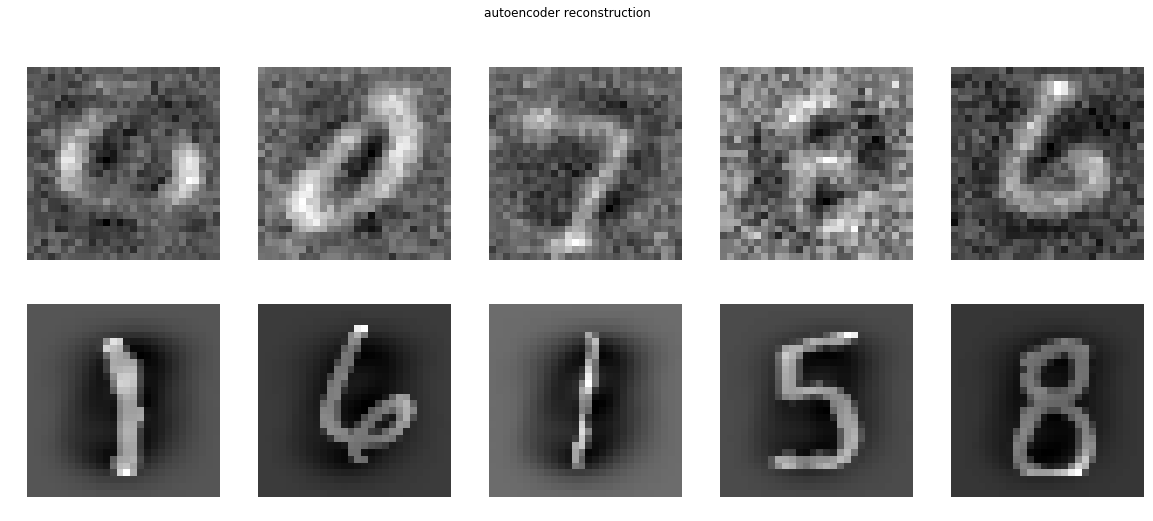

In [8]:
reconstructed_digit_examples = reconstructed_digits[:10, :].asnumpy()

plot_two_img_rows(reconstructed_digit_examples[:10], X_valid[:10], 'autoencoder reconstruction')

### Adding dropout 

In [14]:
data = sym.Variable('data')
weights = sym.Dropout(
  p=0.2, 
  data=sym.Variable(
     name='weighs',
     shape=(input_size, hidden_size),
     init=mx.init.Xavier(),
     dtype='float32')
)
hid_in = sym.dot(data, weights, name='hidden_in')
codes = sym.Activation(hid_in, act_type='relu', name='codes')
hid_out = sym.dot(codes, weights.transpose(), name='hidden_out')
loss = mx.symbol.MakeLoss(
  mx.symbol.LinearRegressionOutput(data=hid_out, label=data)
)

nn = mod.Module(symbol=loss, label_names=['data'])

In [15]:
%time nn.fit(train_iter, num_epoch=100, eval_metric='rmse', optimizer_params={'learning_rate': 0.5})

Epoch[0] Train-rmse=0.973010
Epoch[0] Time cost=1.230
Epoch[1] Train-rmse=0.958630
Epoch[1] Time cost=1.259
Epoch[2] Train-rmse=0.949631
Epoch[2] Time cost=1.507
Epoch[3] Train-rmse=0.941421
Epoch[3] Time cost=1.294
Epoch[4] Train-rmse=0.936865
Epoch[4] Time cost=1.238
Epoch[5] Train-rmse=0.931877
Epoch[5] Time cost=1.286
Epoch[6] Train-rmse=0.928315
Epoch[6] Time cost=1.223
Epoch[7] Train-rmse=0.925332
Epoch[7] Time cost=1.271
Epoch[8] Train-rmse=0.922627
Epoch[8] Time cost=1.398
Epoch[9] Train-rmse=0.919875
Epoch[9] Time cost=1.723
Epoch[10] Train-rmse=0.918442
Epoch[10] Time cost=1.717
Epoch[11] Train-rmse=0.916600
Epoch[11] Time cost=1.340
Epoch[12] Train-rmse=0.914876
Epoch[12] Time cost=1.541
Epoch[13] Train-rmse=0.912832
Epoch[13] Time cost=1.472
Epoch[14] Train-rmse=0.911537
Epoch[14] Time cost=1.925
Epoch[15] Train-rmse=0.909789
Epoch[15] Time cost=1.419
Epoch[16] Train-rmse=0.908397
Epoch[16] Time cost=1.149
Epoch[17] Train-rmse=0.907106
Epoch[17] Time cost=1.204
Epoch[18] Tr

In [16]:
nn.score(test_iter, eval_metric='rmse')
reconstructed_digits = nn.predict(valid_iter)

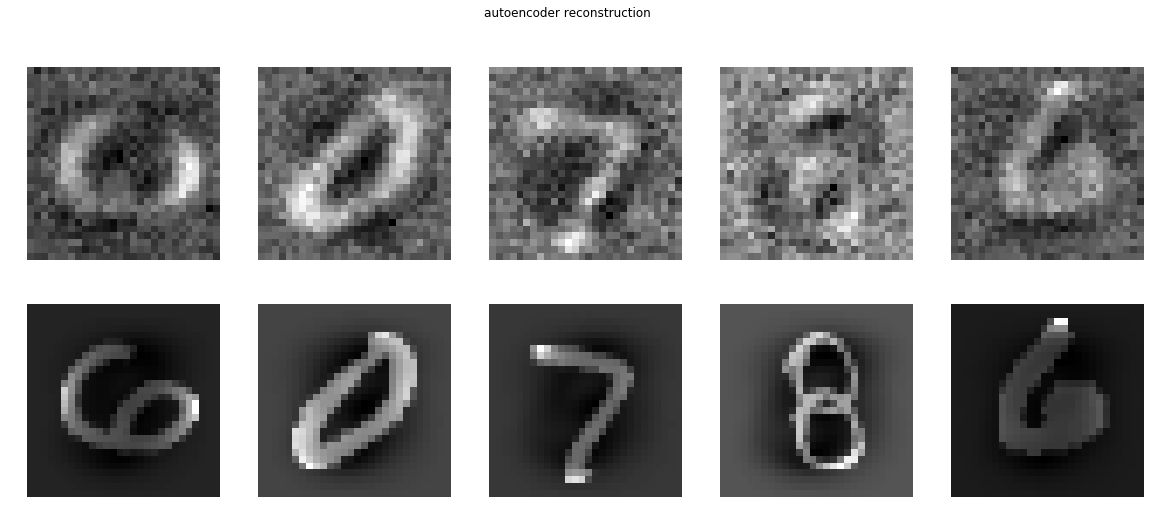

In [17]:
reconstructed_digit_examples = reconstructed_digits[:10, :].asnumpy()

plot_two_img_rows(reconstructed_digit_examples[:10], X_valid[:10], 'autoencoder reconstruction')